In [2]:
import os
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
workspace_path = "/Users/ranakaya/Downloads/GoruntuVeriseti/hard-fake-vs-real-faces/"
# Veri dönüşümleri
transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Veri setlerinin yüklenmesi
train_dataset = ImageFolder(root=os.path.join(workspace_path, "train"), transform=transform)
val_dataset = ImageFolder(root=os.path.join(workspace_path, "validation"), transform=transform)
test_dataset = ImageFolder(root=os.path.join(workspace_path, "test"), transform=transform)

# Veri yükleyicileri
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [4]:
class CustomAlexNetModel(nn.Module):
    def __init__(self):
        super(CustomAlexNetModel, self).__init__()
        self.base_model = torchvision.models.alexnet(pretrained=True)
        num_features = self.base_model.classifier[-1].in_features
        self.base_model.classifier[-1] = nn.Linear(num_features, 1)

    def forward(self, x):
        return torch.sigmoid(self.base_model(x))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CustomAlexNetModel().to(device)

# Kayıp fonksiyonu ve optimizer
criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

/opt/anaconda3/envs/torchimg/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/envs/torchimg/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /Users/ranakaya/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100.0%


In [5]:
num_epochs = 20
best_accuracy = 0.0
early_stopping_counter = 0

train_losses = []
train_accuracies = []
validation_losses = []
validation_accuracies = []

for epoch in range(num_epochs):
    # Eğitim aşaması
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.float().to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels.unsqueeze(1))
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)

        predicted = torch.round(outputs)
        total += labels.size(0)
        correct += (predicted == labels.unsqueeze(1)).sum().item()

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_accuracy = correct / total
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)

    # Doğrulama aşaması
    model.eval()
    running_val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.float().to(device)
            outputs = model(images)
            loss = criterion(outputs, labels.unsqueeze(1))
            running_val_loss += loss.item() * images.size(0)
            predicted = torch.round(outputs)
            total += labels.size(0)
            correct += (predicted == labels.unsqueeze(1)).sum().item()

    val_loss = running_val_loss / len(val_loader.dataset)
    val_accuracy = correct / total
    validation_losses.append(val_loss)
    validation_accuracies.append(val_accuracy)


    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_accuracy:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")
    # Early stopping kontrolü
    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        early_stopping_counter = 0
    else:
        early_stopping_counter += 1
        if early_stopping_counter >= 5:
            print("Early stopping triggered.")
            break


Epoch 1/20, Train Loss: 0.2472, Train Accuracy: 0.9012, Validation Loss: 0.1076, Validation Accuracy: 0.9650
Epoch 2/20, Train Loss: 0.0561, Train Accuracy: 0.9811, Validation Loss: 0.0072, Validation Accuracy: 1.0000
Epoch 3/20, Train Loss: 0.0125, Train Accuracy: 0.9967, Validation Loss: 0.0054, Validation Accuracy: 1.0000
Epoch 4/20, Train Loss: 0.0035, Train Accuracy: 1.0000, Validation Loss: 0.0046, Validation Accuracy: 1.0000
Epoch 5/20, Train Loss: 0.0044, Train Accuracy: 0.9989, Validation Loss: 0.0037, Validation Accuracy: 1.0000
Epoch 6/20, Train Loss: 0.0020, Train Accuracy: 1.0000, Validation Loss: 0.0021, Validation Accuracy: 1.0000
Epoch 7/20, Train Loss: 0.0017, Train Accuracy: 1.0000, Validation Loss: 0.0021, Validation Accuracy: 1.0000
Early stopping triggered.


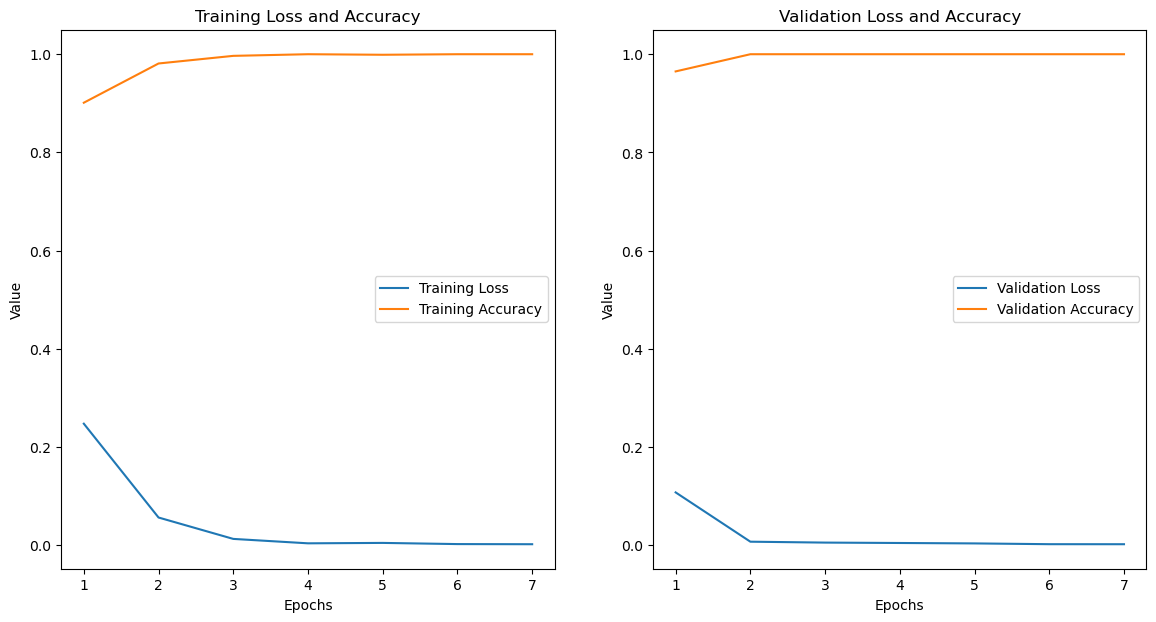

In [6]:
# Listelerin uzunluklarını kontrol etme ve en kısa listenin uzunluğunu bulma
min_length = min(len(train_losses), len(validation_losses), len(train_accuracies), len(validation_losses), num_epochs)

# Tüm listeleri en kısa uzunluğa göre kesme
train_losses = train_losses[:min_length]
val_losses = validation_losses[:min_length]
train_accuracies = train_accuracies[:min_length]
val_accuracies = validation_accuracies[:min_length]

# Grafik çizme
plt.figure(figsize=(14, 7))

# Eğitim Kayıpları ve Doğrulukları Grafiği
plt.subplot(1, 2, 1)
plt.plot(range(1, min_length + 1), train_losses, label='Training Loss')
plt.plot(range(1, min_length + 1), train_accuracies, label='Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.title('Training Loss and Accuracy')
plt.legend()

# Doğrulama Kayıpları ve Doğrulukları Grafiği
plt.subplot(1, 2, 2)
plt.plot(range(1, min_length + 1), val_losses, label='Validation Loss')
plt.plot(range(1, min_length + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.title('Validation Loss and Accuracy')
plt.legend()

plt.show()


In [10]:
destination_folder = "/Users/ranakaya/GoruntuIslemeGuncel/SavedModel"
torch.save(model.state_dict(), f"{destination_folder}/AlexNet.pth")

In [7]:
# Test
model.eval()
predictions = []
true_labels = []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.float().to(device)
        outputs = model(images)
        predicted = torch.round(outputs)
        predictions.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

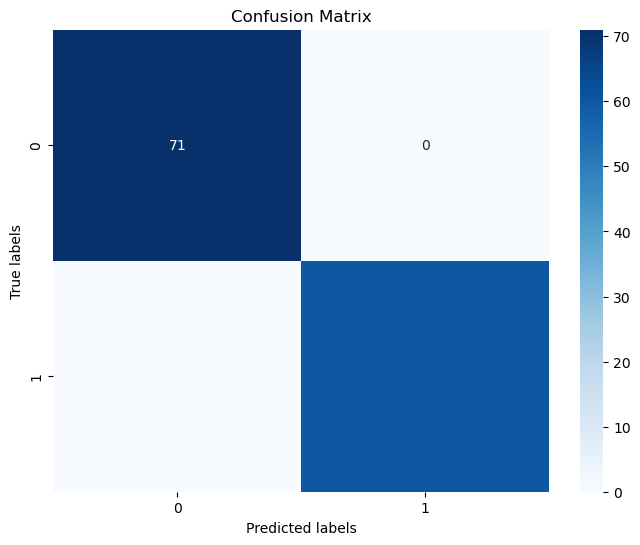

<function confusion_matrix at 0x174f663b0>


In [8]:
# Confusion matrix ve görselleştirme
conf_matrix = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()
print(confusion_matrix)

In [9]:
print(conf_matrix)

[[71  0]
 [ 0 60]]
